In [29]:
# -*- coding: utf-8 -*-
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD
from time import time
from numpy.random import RandomState
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# PART 1

Dataset consists of 400 faces


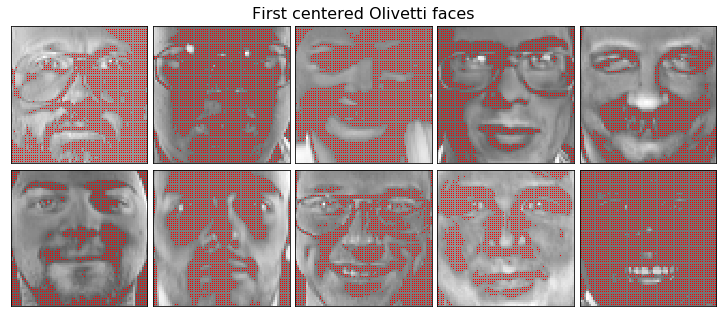

In [30]:
# -- Prepare data and define utility functions ---------------------------------
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(data_home='c:/tmp/',shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print("Dataset consists of %d faces" % n_samples)

def plot_gallery(title, images):
    pl.figure(figsize=(2. * n_col, 2.26 * n_row))
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)

        comp = comp.reshape(image_shape).copy()
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0:
            yz, xz = dmy
        comp[comp<0] = 0

        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        #print "vmax: %f, vmin: %f" % (vmax, vmin)
        #print comp

        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')#, hold=True)
            #print(len(dmy[0]), "negative-valued pixels")

        pl.xticks(())
        pl.yticks(())

    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])


In [4]:
# -- Decomposition methods -----------------------------------------------------

# List of the different estimators and whether to center the data

estimators = [
    ('pca', 'Eigenfaces - PCA', decomposition.PCA(n_components=n_components, whiten=True),True),
    ('nmf', 'Non-negative components - NMF', decomposition.NMF(n_components=n_components, init='random', tol=1e-6,max_iter=1000), False)
]


Extracting the top 10 Eigenfaces - PCA...
done in 0.174s
[0.8675]

Extracting the top 10 Non-negative components - NMF...
done in 11.616s
[0.855]


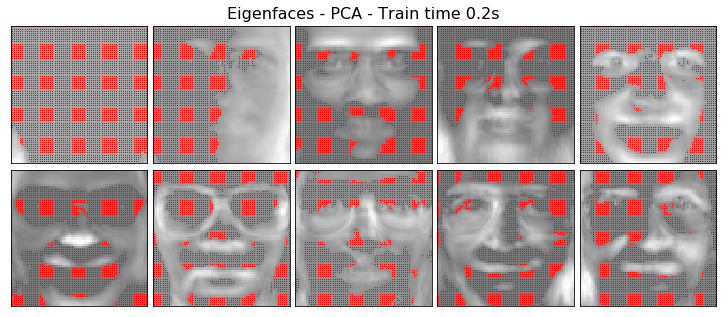

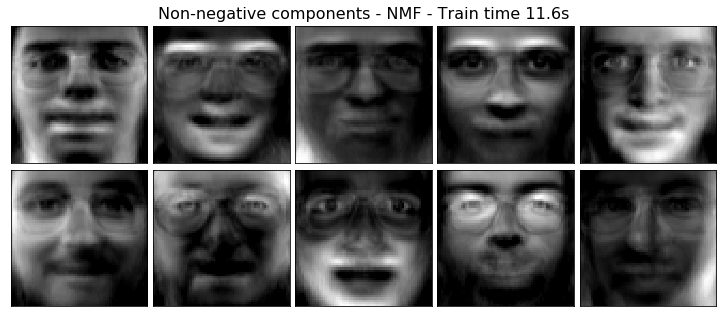

In [31]:
# -- Transform and classify ----------------------------------------------------

labels = dataset.target
X  = faces
X_ = faces_centered

y_pred = np.zeros((2,len(labels)))
scores = np.zeros((2,1))
i = 0
for shortname, name, estimator, center in estimators:

    data = X
    if center:
        data = X_
        
    print("\nExtracting the top %d %s..." % (n_components, name))
    t0 = time()

    data = estimator.fit_transform(data)

    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)

    components_ = estimator.components_

    plot_gallery('%s - Train time %.1fs' % (name, train_time), components_[:n_components])
    
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    lda = lda.fit(data, labels)
    scores[i] = np.mean(cross_val_score(lda, data, labels, cv=5))
    print(scores[i])
    
    i += 1


 Eigenfaces - PCA ...

 Non-negative components - NMF ...


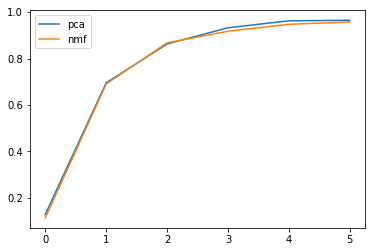

In [36]:
grid = np.arange(1,30,5)
y_pred = np.zeros((2,len(labels)))
scores = np.zeros((2,1))
i = 0
for shortname, name, estimator, center in estimators:
    data = X
    if center:
        data = X_
     
    param_grid = {shortname+'__n_components': grid}
    
    print("\n %s ..." % ( name))
    t0 = time()

    LDA    = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    pipe   = Pipeline(steps=[(shortname, estimator), ('LDA', LDA)])
    search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
    search = search.fit(data, labels)
    
    pl.plot(grid,search.cv_results_["mean_test_score"],label=shortname)
    
    train_time = (time() - t0)

    i += 1
    
pl.legend()
pl.xlabel('n_component'),pl.ylabel('score')
pl.show()

# PART 2

In [39]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
# License: Simplified BSD

from time import time
from sklearn.feature_extraction import text
from sklearn import decomposition
from sklearn import datasets

n_samples = 1000
n_features = 900
n_topics = 4
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it using the most common word
# frequency with TF-IDF weighting (without top 5% stop words)

t0 = time()

# Load some categories from the training set
categories = ['rec.sport.baseball','comp.graphics', 'comp.sys.mac.hardware', 'talk.religion.misc']

print("Loading dataset and extracting TF-IDF features...")
dataset = datasets.fetch_20newsgroups(data_home='c:/data/', shuffle=True, categories=categories, random_state=1)

vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features, stop_words='english')
counts = vectorizer.fit_transform(dataset.data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
print("done in %0.3fs." % (time() - t0))


Loading dataset and extracting TF-IDF features...
done in 0.552s.


In [40]:
# Fit the NMF model
print("Fitting the NMF model on with n_samples=%d and n_features=%d..." % ( n_samples, n_features))
nmf = decomposition.NMF(n_components=n_topics).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Fitting the NMF model on with n_samples=1000 and n_features=900...
done in 2.247s.
Topic #0:
edu year article team baseball cs players writes game university runs host nntp posting jewish good hit season games win
Topic #1:
graphics files file uk thanks ac 3d program package help ca image windows university computer need format posting use com
Topic #2:
com god jesus sandvik people christian writes bible don kent christians brian netcom koresh article life said newton just apple
Topic #3:
mac apple edu drive scsi quadra monitor problem video centris duo se problems card power drives software internal disk ram


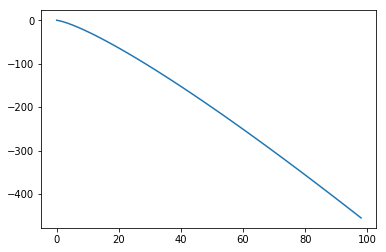

In [47]:
x = np.arange(1,100)
pl.plot(x*np.log(1/x))